## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import libraries

In [2]:
import os
import cv2
import glob
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks_cwt


## 1. Camera calibration using chessboard images

In [6]:
def camera_calibration(image_tmpl, output_dir='.'):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    h, w = 6, 9
    obj_pt = np.zeros((h*w, 3), np.float32)
    obj_pt[:, :2] = np.mgrid[0:w, 0:h].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    obj_pts = [] # 3d points in real world space
    img_pts = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(image_tmpl)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (w, h), None)

        if ret == True:
            obj_pts.append(obj_pt)
            img_pts.append(corners)

    # Do camera calibration given object points and image points
    img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(obj_pts, img_pts, img_size, None, None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    output_file = os.path.join(output_dir, 'dist_pickle.p')
    pickle.dump(dist_pickle, open(output_file, 'wb'))
    return (mtx, dist)
    
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

## 2. Undistort raw image

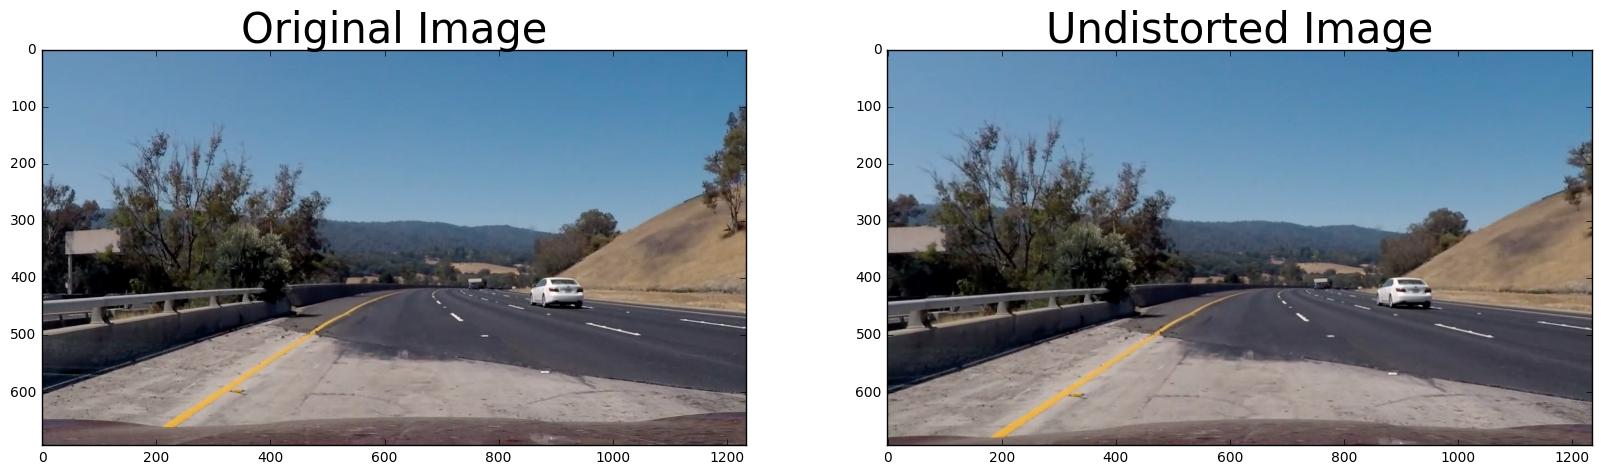

In [194]:
def load_undistort_params(input_dir='.'):
    input_file = os.path.join(input_dir, 'dist_pickle.p')
    dist_pickle = pickle.load(open(input_file, 'rb'))
    return (dist_pickle['mtx'], dist_pickle['dist'])

def undistort_image(image, mtx, dist):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# Test undistortion on an image
img = cv2.imread('test_images/challenge6.jpg')
mtx, dist = load_undistort_params()
dst = undistort_image(img, mtx, dist)
cv2.imwrite('test_images/challenge6_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

## 3. Perspective transform

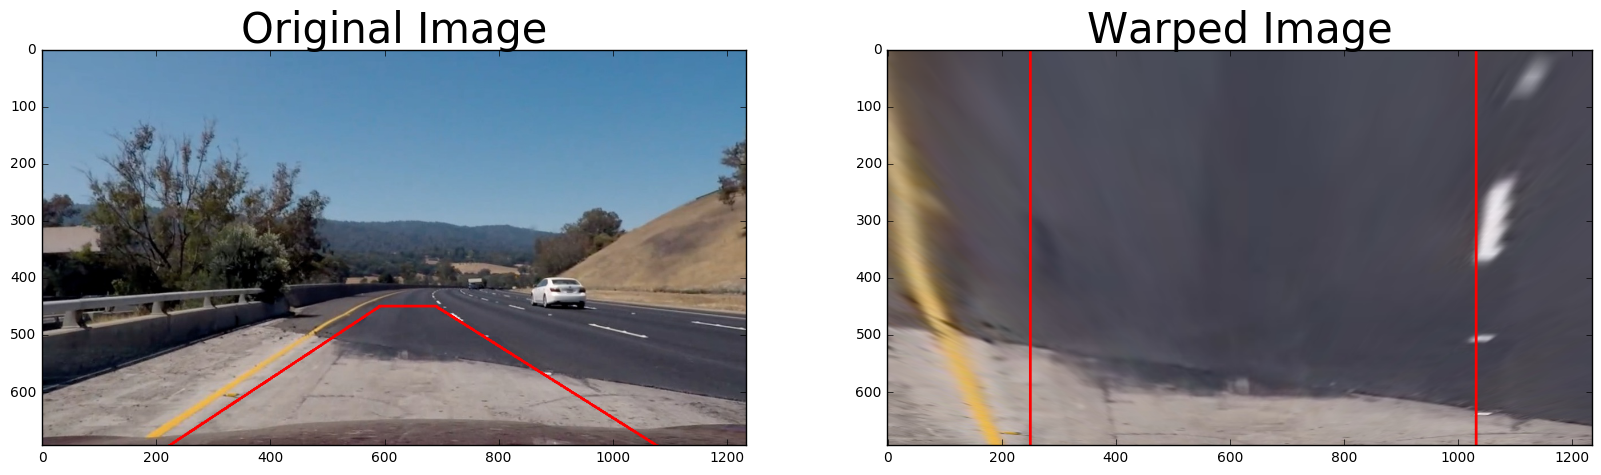

In [195]:
def perspective_transform(image, inverse=False):
    
    src = np.float32([(592, 450), (689, 450), (205, 706), (1095, 706)])
    dst = np.float32([(250, 0), (1030, 0), (250, 720), (1030, 720)])
    
    if inverse:
        src, dst = dst, src
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, None, flags=cv2.INTER_LINEAR)
    
    return warped, M

dst = cv2.imread('test_images/challenge6_undist.jpg')
warped, M = perspective_transform(dst)

# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
pts = np.array([(592, 450), (689, 450), (1095, 706), (205, 706)])
dst_line = dst.copy()
cv2.polylines(dst_line, [pts], True, (0, 0, 255), thickness=3)
ax1.imshow(cv2.cvtColor(dst_line, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)

pts = np.array([(250, 0), (1030, 0), (1030, 720), (250, 720)])
warped_line = warped.copy()
cv2.polylines(warped_line, [pts], True, (0, 0, 255), thickness=3)
ax2.imshow(cv2.cvtColor(warped_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Warped Image', fontsize=30)

## 4. Create Threshold Binary Image (Color & Graident)

### Histogram Equalization

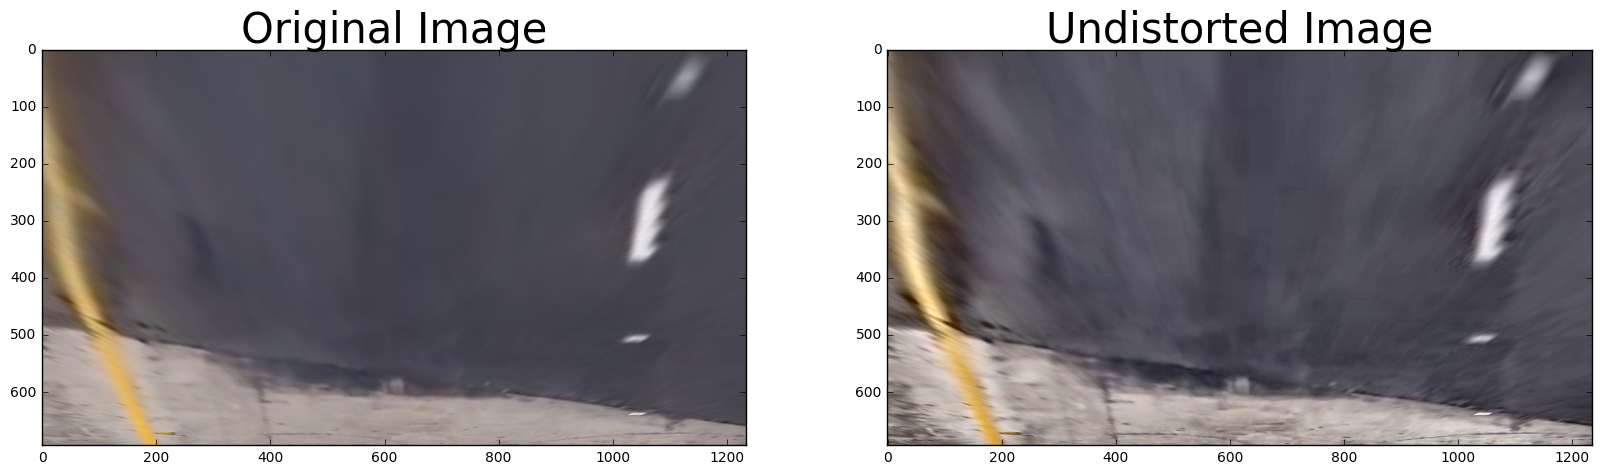

In [196]:
def histogram_equalization(image):
    """
    http://docs.opencv.org/3.2.0/d5/daf/tutorial_py_histogram_equalization.html
    """
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return image

equalized = histogram_equalization(warped)
    
# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

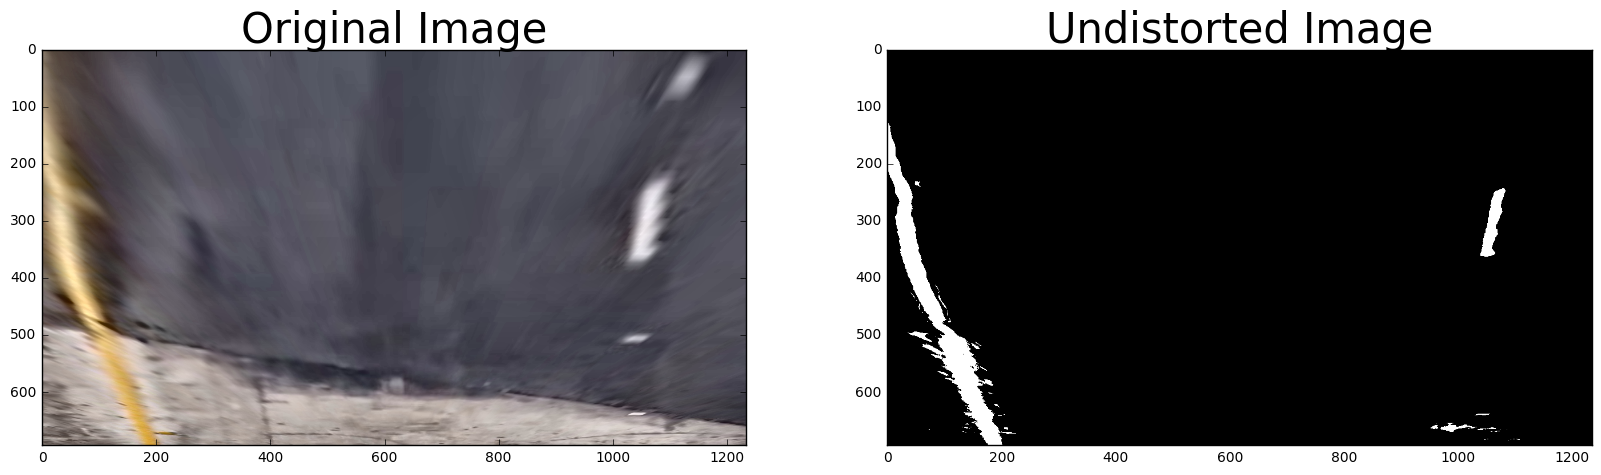

In [197]:
def create_threshold_binary_image(image, print_color=False):
    image = np.copy(image)
    
    # convert color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)

    # sobel x (derivative in x axis)
    s_sobelx = cv2.Sobel(hls[:,:,2], cv2.CV_64F, 1, 0)
    s_abs_sobelx = np.abs(s_sobelx)
    s_scaled_sobel = np.uint8(255*s_abs_sobelx/np.max(s_abs_sobelx))
    
    l_sobelx = cv2.Sobel(hls[:,:,1], cv2.CV_64F, 1, 0)
    l_abs_sobelx = np.abs(l_sobelx)
    l_scaled_sobel = np.uint8(255*l_abs_sobelx/np.max(l_abs_sobelx))
    
    # threshold x gradient
    sobel_min = np.array([20])
    sobel_max = np.array([100])
    s_sx_mask = cv2.inRange(s_scaled_sobel, sobel_min, sobel_max)
    l_sx_mask = cv2.inRange(l_scaled_sobel, sobel_min, sobel_max)
    sx_mask = s_sx_mask.astype('bool') & l_sx_mask.astype('bool')
    
    # threshold color channel    
    yellow_min  = np.array([ 15,  80,  95])
    yellow_max  = np.array([100, 230, 255])
    yellow_mask = cv2.inRange(hls, yellow_min, yellow_max)
    
    white_min  = np.array([  0, 210,  10])
    white_max  = np.array([255, 255, 255])
    white_mask = cv2.inRange(hls, white_min, white_max)
    
    if print_color:
        return np.dstack((sx_mask, yellow_mask, white_mask))

    binary = np.zeros_like(image[:,:,0])
    binary[
        #sx_mask.astype('bool') | 
        yellow_mask.astype('bool') | 
        white_mask.astype('bool')] = 1
    
    binary = cv2.erode(binary, (5, 5), iterations=1)
    return binary
    
binary_img = create_threshold_binary_image(equalized, print_color=False)
    
# Visualize transformed images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(equalized, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=30)

## 5. Find lane lines

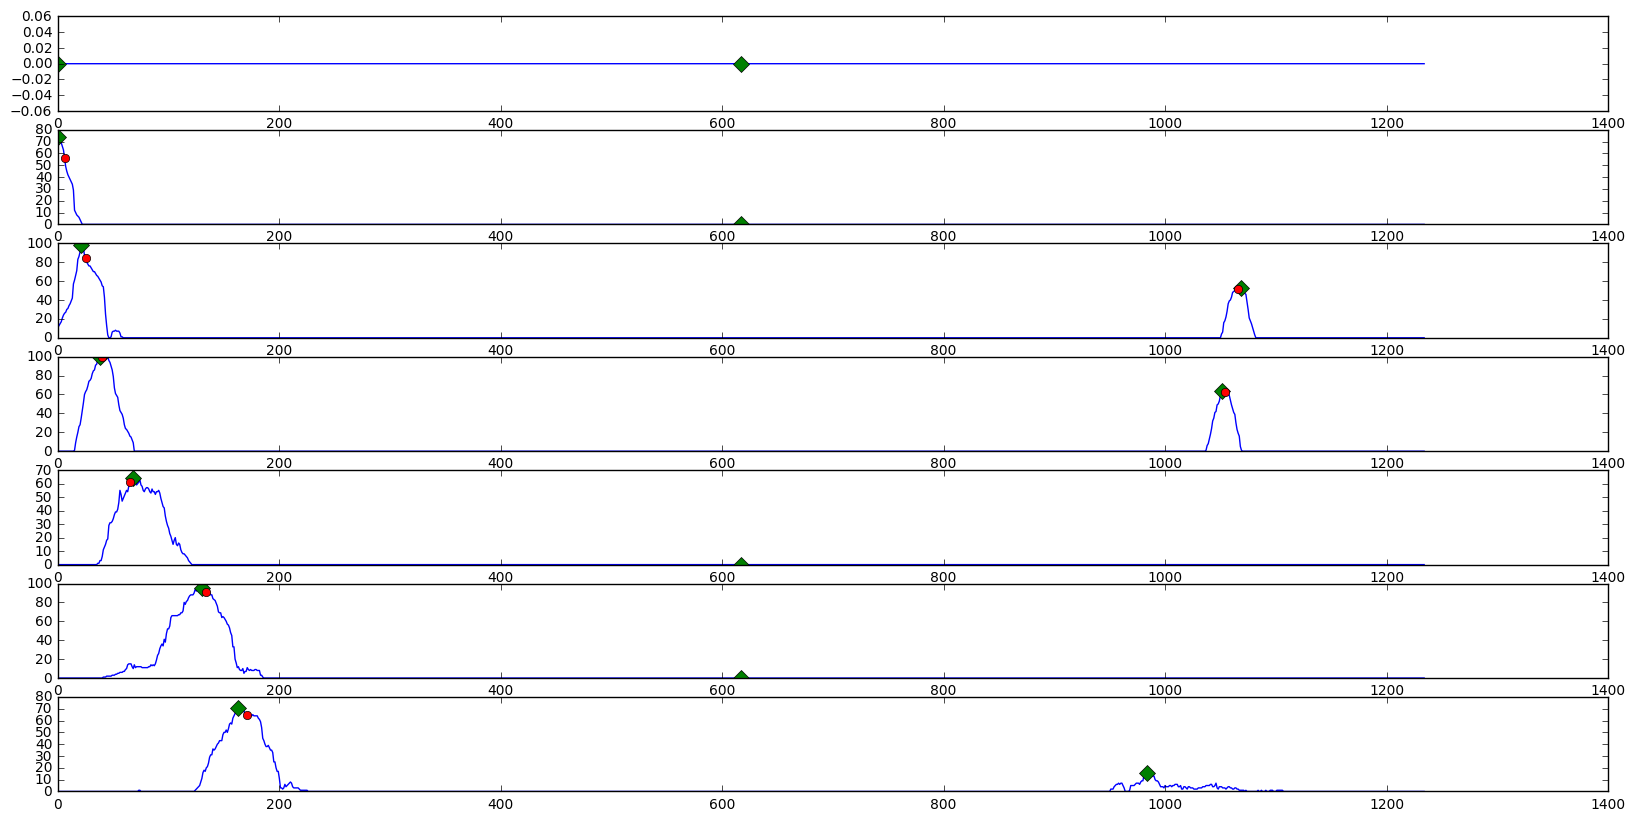

In [198]:
# Visiualize sliding window
# https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
binary_img = create_threshold_binary_image(equalized)
nb_win = 7
width = binary_img.shape[1]
height = binary_img.shape[0]
win_size = math.ceil(height/nb_win)

f, axes = plt.subplots(nb_win, 1, figsize=(20,10))
for i, ax in enumerate(axes):
    start = i * win_size
    end = start + win_size
    
    histogram = np.sum(binary_img[start:end,:], axis=0)
    ax.plot(histogram)
    
    # argmax
    mid = width // 2
    l_peak = np.argmax(histogram[:mid])
    r_peak = np.argmax(histogram[mid:]) + mid
    ax.plot([l_peak, r_peak], histogram[[l_peak, r_peak]], 'D', color='g', ms=8)
    
    # peak
    indexes = find_peaks_cwt(histogram, np.arange(10, 100))
    indexes = [idx for idx in indexes if histogram[idx] > 20]
    ax.plot(indexes, histogram[indexes], 'o', color='red')
    

Window (0)
Window (1)
Window (2)
Window (3)
Left lane not found. Delta: 120
Window (4)
Left lane not found. Delta: 160
Window (5)
Left lane not found. Delta: 200
Window (6)
Left lane not found. Delta: 240


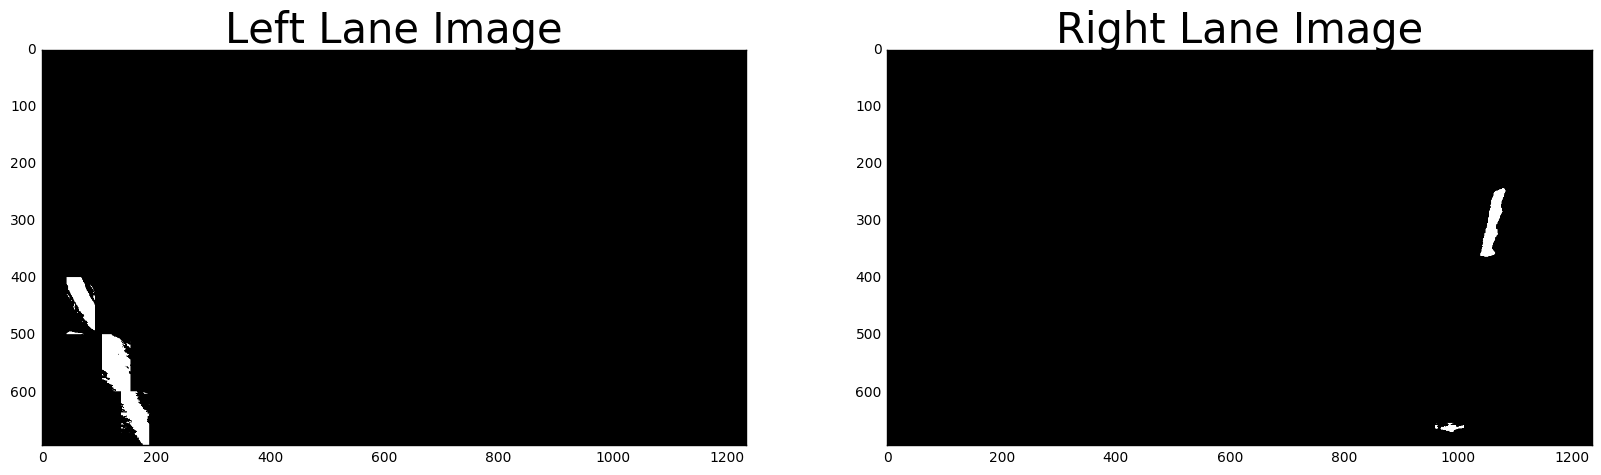

In [207]:
def find_lane_points(binary_image, show_image=False):
    """
    """
    lane_width = 25
    lanes_dist = 700
    tolerance  = 150
    #lanes_dist = 780
    #tolerance  = 70

    delta1 = 80
    delta2 = 40
    l_delta = delta1
    r_delta = delta1
    
    mid = int(binary_img.shape[1]/2)
    width  = binary_image.shape[1]
    height = binary_image.shape[0]
    
    nb_win = 7
    win_size = math.ceil(height/nb_win)

    l_y_vals = []
    l_x_vals = []
    
    r_y_vals = []
    r_x_vals = []
    
    l_pnts = np.zeros_like(binary_image)
    r_pnts = np.zeros_like(binary_image)
    
    l_peak = None
    r_peak = None
    
    l_prev = None
    r_prev = None
    
    for i in range(nb_win):
        if show_image:
            print('Window ({})'.format(i))
        idx = (nb_win - 1) - i

        start = idx * win_size
        end = start + win_size

        histogram = np.sum(binary_image[start:end, :], axis=0)

        # first band
        if not l_prev or not r_prev:
            l_peak = np.argmax(histogram[:mid])
            r_peak = np.argmax(histogram[mid:]) + mid

        # rest of bands
        else:
            l_hist = histogram[l_prev-l_delta:l_prev+l_delta]
            r_hist = histogram[r_prev-r_delta:r_prev+r_delta]
                
            l_peak = np.argmax(l_hist) + l_prev-l_delta if len(l_hist) > 0 else None
            r_peak = np.argmax(r_hist) + r_prev-r_delta if len(r_hist) > 0 else None
            
        # Valid lane line found
        if (l_prev and r_prev) or abs((r_peak - l_peak) - lanes_dist) < tolerance:
            
            if l_peak:
                l_mask = binary_image[start:end, l_peak-lane_width:l_peak+lane_width] == 1
                if l_mask.sum() > 50:
                    l_pnts[start:end, l_peak-lane_width:l_peak+lane_width][l_mask] = 1
                    l_prev = l_peak
                    l_delta = delta1
                else:
                    l_delta += delta2
            else:
                l_delta += delta2
                if show_image:
                    print('Left lane not found. Delta: {}'.format(l_delta))
                
            if r_peak:
                r_mask = binary_image[start:end, r_peak-lane_width:r_peak+lane_width] == 1
                if r_mask.sum() > 50:
                    r_pnts[start:end, r_peak-lane_width:r_peak+lane_width][r_mask] = 1
                    r_prev = r_peak
                    r_delta = delta1
                else:
                    r_delta += delta2
            else:
                r_delta += delta2
                if show_image:
                    print('Right lane not found. Delta: {}'.format(r_delta))

    if show_image:        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(l_pnts, cmap='gray')
        ax1.set_title('Left Lane Image', fontsize=30)
        ax2.imshow(r_pnts, cmap='gray')
        ax2.set_title('Right Lane Image', fontsize=30)
    return np.where(l_pnts == 1), np.where(r_pnts == 1), l_pnts, r_pnts

l_points, r_points, _, _ = find_lane_points(binary_img, show_image=True)

## 6. Measure Curvature

1100.34252656 152096.341808


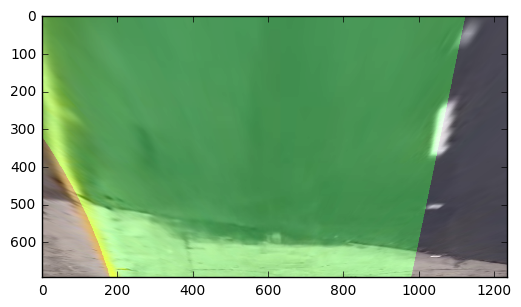

In [208]:
def fit_poly(x_vals, y_vals, y_max):
    # fit second order polynomial
    line_fit = np.polyfit(y_vals, x_vals, 2)
    
    # calculate radius of curvature
    curverad = ((1 + (2*line_fit[0]*y_max + line_fit[1])**2)**1.5) \
                             /np.absolute(2*line_fit[0])
    return line_fit, curverad

l_fit, l_curverad = fit_poly(l_points[1], l_points[0], height)
r_fit, r_curverad = fit_poly(r_points[1], r_points[0], height)
print (l_curverad, r_curverad)

# Create an image to draw the lines on
color_warp  = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
y_vals = np.linspace(0, 100, num=101)*7.2 
l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
result = cv2.addWeighted(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), 1, color_warp, 0.3, 0)
plt.imshow(result)

## 7. 8. Reversed Perspective Transform

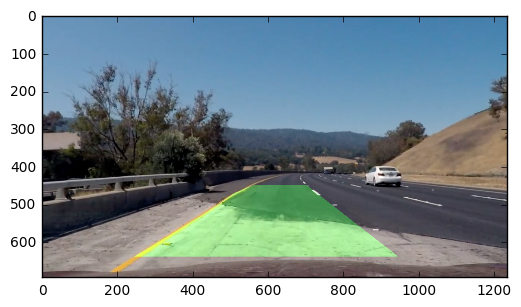

In [209]:
def create_lane_boundary_image(l_fit, r_fit, image):

    # Create an image to draw the lines on
    color_warp  = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    y_vals = np.linspace(0, 100, num=101)*(image.shape[1]/100)
    l_x_fit = l_fit[0]*y_vals**2 + l_fit[1]*y_vals + l_fit[2]
    r_x_fit = r_fit[0]*y_vals**2 + r_fit[1]*y_vals + r_fit[2]

    pts_left  = np.array([np.transpose(np.vstack([l_x_fit, y_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_x_fit, y_vals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    return color_warp

boundary_dst = create_lane_boundary_image(l_fit, r_fit, dst)
boundary_dst, M = perspective_transform(boundary_dst, inverse=True)

result = cv2.addWeighted(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB), 1, boundary_dst, 0.3, 0)
plt.imshow(result)


## Video

In [103]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [210]:
mtx, dist = load_undistort_params()

def process_image(image):

    image = image.copy()
    
    undist = undistort_image(image, mtx, dist)
    warped, M = perspective_transform(undist)
    equalized = histogram_equalization(warped)
    binary = create_threshold_binary_image(equalized)
    l_points, r_points, l_pnts, r_pnts = find_lane_points(binary)
    boundary_dst = None
    
    if len(l_points[0]) > 0 and len(l_points[1]) > 0 and len(r_points[0]) > 0 and len(r_points[1]) > 0:
        l_fit, l_curverad = fit_poly(l_points[1], l_points[0], height)
        r_fit, r_curverad = fit_poly(r_points[1], r_points[0], height)

        boundary_dst = create_lane_boundary_image(l_fit, r_fit, undist)
        boundary_dst, M = perspective_transform(boundary_dst, inverse=True)

        result = cv2.addWeighted(undist, 1, boundary_dst, 0.3, 0)   
    else:
        result = undist
        
    # combine images
    if boundary_dst is None:
        boundary_dst = np.zeros_like(result)
    new_h = image.shape[0]//2
    new_w = image.shape[1]//2
    output = np.zeros_like(image)
    
    undist = cv2.resize(undist, (0, 0), fx=.5, fy=.5)
    binary = cv2.resize(binary, (0, 0), fx=.5, fy=.5)
    l_pnts = cv2.resize(l_pnts, (0, 0), fx=.5, fy=.5)
    r_pnts = cv2.resize(r_pnts, (0, 0), fx=.5, fy=.5)

    binary[binary > 0] = 255
    l_pnts[l_pnts > 0] = 255
    r_pnts[r_pnts > 0] = 255
    boundary_dst = cv2.resize(boundary_dst, (0, 0), fx=.5, fy=.5)
    result = cv2.resize(result, (0, 0), fx=.5, fy=.5)
    output[:new_h,:new_w] = undist
    output[new_h:, :new_w] = np.dstack([binary, l_pnts, r_pnts])
    output[:new_h, new_w:] = boundary_dst
    output[new_h:, new_w:] = result
    return output 


In [213]:
output = 'videos/project_video_output.mp4'
clip_in = VideoFileClip("videos/project_video.mp4")#.subclip(20,30)
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/project_video_output.mp4
[MoviePy] Writing video videos/project_video_output.mp4



100%|█████████▉| 1260/1261 [03:46<00:00,  5.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_output.mp4 

CPU times: user 4min 23s, sys: 1min 22s, total: 5min 46s
Wall time: 3min 47s


In [193]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [212]:
output = 'videos/challenge_video_output.mp4'
clip_in = VideoFileClip("videos/challenge_video.mp4").subclip(0,10)
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/challenge_video_output.mp4
[MoviePy] Writing video videos/challenge_video_output.mp4



100%|██████████| 300/300 [00:51<00:00,  5.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/challenge_video_output.mp4 

CPU times: user 59.8 s, sys: 19.1 s, total: 1min 18s
Wall time: 52.4 s


In [109]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [82]:
output = 'videos/harder_challenge_video_output.mp4'
clip_in = VideoFileClip("videos/harder_challenge_video.mp4")#.subclip(0,10)
clip_out = clip_in.fl_image(process_image)
%time clip_out.write_videofile(output, audio=False)

[MoviePy] >>>> Building video videos/harder_challenge_video_output.mp4
[MoviePy] Writing video videos/harder_challenge_video_output.mp4



 26%|██▌       | 310/1200 [00:37<01:35,  9.36it/s]

TypeError: expected non-empty vector for x

In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Line Class

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### Draw lines

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)